<a href="https://colab.research.google.com/github/annasuranyi/NLP_Projekt/blob/main/NLP_Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Szöveg alapú ajánlórendszer**

#1. Könyvtárak telepítése

In [27]:
pip install requests pandas scikit-learn

#2. Projekt kódja

## Adatok létrehozása - TMDB API kulcs megadása

In [2]:
import requests
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

API_KEY = "6b5bdc65c4ca681df7bbe2158ba996ee"  # Cseréld le a saját TMDB API kulcsodra
BASE_URL = "https://api.themoviedb.org/3"

def fetch_movies(api_key, num_movies=20):
    """
    Lekéri a TMDB API-ból az aktuálisan népszerű filmeket.

    Paraméterek:
        api_key (str): A TMDB API kulcs.
        num_movies (int): A lekérendő filmek száma (max. 20 per hívás).

    Return:
        DataFrame: A filmek címét, leírását és műfajait tartalmazó DataFrame.
    """
    # Népszerű filmek lekérdezése
    url = f"{BASE_URL}/movie/popular"
    params = {"api_key": api_key, "language": "en-US", "page": 1}
    response = requests.get(url, params=params)

    if response.status_code != 200:
        raise Exception(f"API hiba: {response.status_code}, {response.text}")

    data = response.json()
    movies = []

    for movie in data["results"][:num_movies]:
        title = movie["title"]
        description = movie.get("overview", "Nincs leírás")
        genres = fetch_genres(movie["genre_ids"], api_key)
        movies.append({"title": title, "description": description, "genres": genres})

    return pd.DataFrame(movies)

def fetch_genres(genre_ids, api_key):
    """
    Lekéri a műfajok nevét az azonosítók alapján.

    Paraméterek:
        genre_ids (list): A műfajok azonosítói.
        api_key (str): A TMDB API kulcs.

    Return:
        str: A műfajok neve vesszővel elválasztva.
    """
    # Műfajok listája (csak egyszer kellene letölteni, itt dinamikusan van megoldva)
    genre_url = f"{BASE_URL}/genre/movie/list"
    params = {"api_key": api_key, "language": "en-US"}
    response = requests.get(genre_url, params=params)

    if response.status_code != 200:
        raise Exception(f"API hiba a műfajok lekérdezésekor: {response.status_code}, {response.text}")

    genres_data = response.json()["genres"]
    genres_dict = {genre["id"]: genre["name"] for genre in genres_data}
    return ", ".join([genres_dict[genre_id] for genre_id in genre_ids if genre_id in genres_dict])

## Adatok letöltése

In [28]:
print("Adatok letöltése a TMDB API-ból...")
df = fetch_movies(API_KEY, num_movies=200)
print("Sikeresen letöltött adatok:")
print(df.head())

Adatok letöltése a TMDB API-ból...
Sikeresen letöltött adatok:
                   title                                        description  \
0                Red One  After Santa Claus (codename: Red One) is kidna...   
1  Venom: The Last Dance  Eddie and Venom are on the run. Hunted by both...   
2                Moana 2  After receiving an unexpected call from her wa...   
3              Elevation  A single father and two women venture from the...   
4  Mufasa: The Lion King  Told in flashbacks, Mufasa is an orphaned cub,...   

                                         genres  
0                       Action, Fantasy, Comedy  
1  Action, Science Fiction, Adventure, Thriller  
2          Animation, Adventure, Family, Comedy  
3             Action, Science Fiction, Thriller  
4           Adventure, Family, Drama, Animation  


## TF-IDF vektorok létrehozása - A TF-IDF vektorok létrehozásához a TfidfVectorizer-t használjuk.

In [29]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['description'])

## Koszinusz hasonlóság kiszámítása - A koszinusz hasonlóság mátrixot a cosine_similarity függvénnyel számoljuk ki.

In [30]:
# A koszinusz hasonlóság mátrix számítása a TF-IDF vektorok alapján
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

## Ajánló funkció - Egy egyszerű ajánló funkció (recommend_movies) kiszámítja a legjobban hasonlító filmeket.

In [31]:
def recommend_movies(title, cosine_sim=cosine_sim):
    """
    Visszaadja a megadott filmhez legjobban hasonlító filmek címét.

    Paraméterek:
        title (str): A film címe, amelyhez hasonlót keresünk.
        cosine_sim (ndarray): A koszinusz hasonlóság mátrix.

    Return:
        list: Az 5 legjobban hasonlító film címe.
    """
    if title not in df['title'].values:
        return ["Nincs ilyen film az adatbázisban."]

    # A film indexének megkeresése a DataFrame-ben
    idx = df[df['title'] == title].index[0]

    # Hasonlósági pontszámok lekérése a kiválasztott filmhez
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Rendezés a hasonlóság szerint, csökkenő sorrendben
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # A top 5 legjobban hasonlító film indexei (kivéve saját maga)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]

    # Visszatérünk a filmek címeivel
    return df['title'].iloc[movie_indices]

## Felhasználói interakció - A felhasználó megadhat egy filmcímet, és a program visszaadja az 5 leginkább hasonló filmet.

In [32]:
if __name__ == "__main__":
    print("\nÜdvözöllek a film ajánló rendszerben!")
    print("Írd be egy film címét, és ajánlok hasonló filmeket.")
    print("Elérhető filmek:")
    print(df['title'].tolist())
    print("\n")

    # Felhasználói bemenet
    user_movie = input("Adj meg egy filmcímet: ")

    # Ajánlások
    recommendations = recommend_movies(user_movie)
    print(f"\nAjánlott filmek az '{user_movie}' című filmhez:")
    for i, movie in enumerate(recommendations, 1):
        print(f"{i}. {movie}")


Üdvözöllek a film ajánló rendszerben!
Írd be egy film címét, és ajánlok hasonló filmeket.
Elérhető filmek:
['Red One', 'Venom: The Last Dance', 'Moana 2', 'Elevation', 'Mufasa: The Lion King', 'Absolution', 'Heretic', 'Sonic the Hedgehog 3', 'The Price of Money: A Largo Winch Adventure', 'The Wild Robot', 'Kraven the Hunter', 'Carry-On', 'Armor', 'Gladiator II', 'The Substance', 'Weekend in Taipei', 'Miraculous World, London: At the Edge of Time', 'That Christmas', 'Watchmen: Chapter II', 'Terrifier 3']


Adj meg egy filmcímet: Moana 2

Ajánlott filmek az 'Moana 2' című filmhez:
1. Sonic the Hedgehog 3
2. Weekend in Taipei
3. Carry-On
4. Miraculous World, London: At the Edge of Time
5. Mufasa: The Lion King


#Statisztika

## Filmek száma

In [33]:
print(f"Film adatbázis mérete: {len(df)} film")

Film adatbázis mérete: 20 film


## Leírások hosszának eloszlása

count     20.000000
mean     247.550000
std      100.288256
min      129.000000
25%      160.000000
50%      215.000000
75%      316.500000
max      482.000000
Name: description_length, dtype: float64


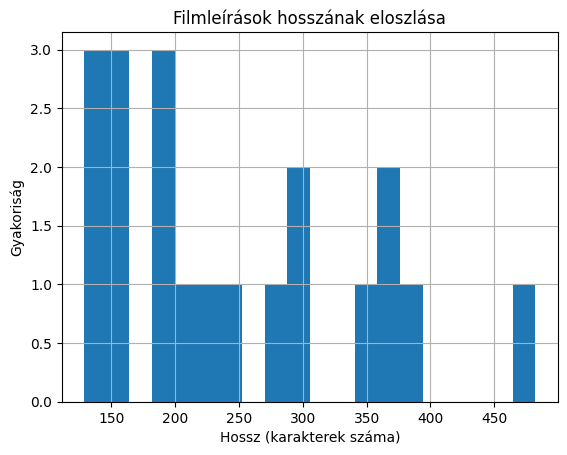

In [34]:
df['description_length'] = df['description'].apply(len)
print(df['description_length'].describe())

# Histogram a hosszok eloszlásáról
import matplotlib.pyplot as plt
df['description_length'].hist(bins=20)
plt.title("Filmleírások hosszának eloszlása")
plt.xlabel("Hossz (karakterek száma)")
plt.ylabel("Gyakoriság")
plt.show()

## Melyek a leggyakoribb műfajok az adathalmazban?

Műfajok gyakorisága:
Action: 14
Adventure: 10
Thriller: 10
Science Fiction: 6
Animation: 6
Family: 5
Comedy: 4
Fantasy: 3
Horror: 3
Drama: 2
Crime: 2
Mystery: 2


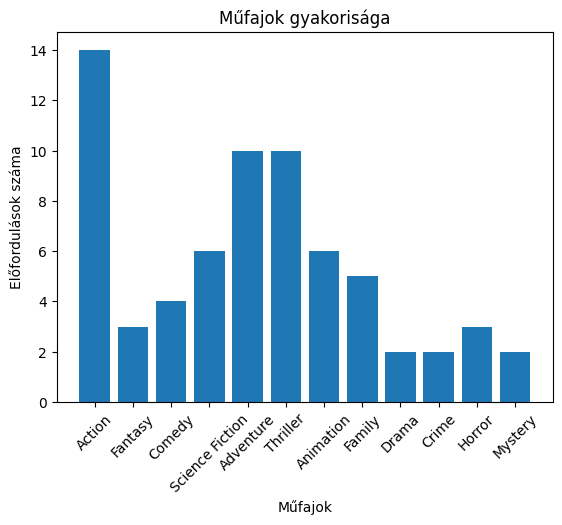

In [35]:
from collections import Counter

genre_counts = Counter(", ".join(df['genres']).split(", "))
print("Műfajok gyakorisága:")
for genre, count in genre_counts.most_common():
    print(f"{genre}: {count}")

# Műfajok megjelenítése oszlopdiagramon
plt.bar(genre_counts.keys(), genre_counts.values())
plt.title("Műfajok gyakorisága")
plt.xlabel("Műfajok")
plt.ylabel("Előfordulások száma")
plt.xticks(rotation=45)
plt.show()

## Átlagos hasonlóság az ajánlásokban

In [36]:
def average_similarity(title, cosine_sim=cosine_sim):
    idx = df[df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # Top 5 ajánlás
    avg_sim = sum([score[1] for score in sim_scores]) / len(sim_scores)
    return avg_sim

df['average_similarity'] = df['title'].apply(average_similarity)
print("Átlagos hasonlóság az ajánlások között:")
print(df[['title', 'average_similarity']])

Átlagos hasonlóság az ajánlások között:
                                            title  average_similarity
0                                         Red One            0.059008
1                           Venom: The Last Dance            0.011749
2                                         Moana 2            0.049310
3                                       Elevation            0.035857
4                           Mufasa: The Lion King            0.028834
5                                      Absolution            0.028905
6                                         Heretic            0.030782
7                            Sonic the Hedgehog 3            0.043416
8     The Price of Money: A Largo Winch Adventure            0.012246
9                                  The Wild Robot            0.006357
10                              Kraven the Hunter            0.036915
11                                       Carry-On            0.047876
12                                          Armor 

## Hasonlósági mátrix vizualizációja

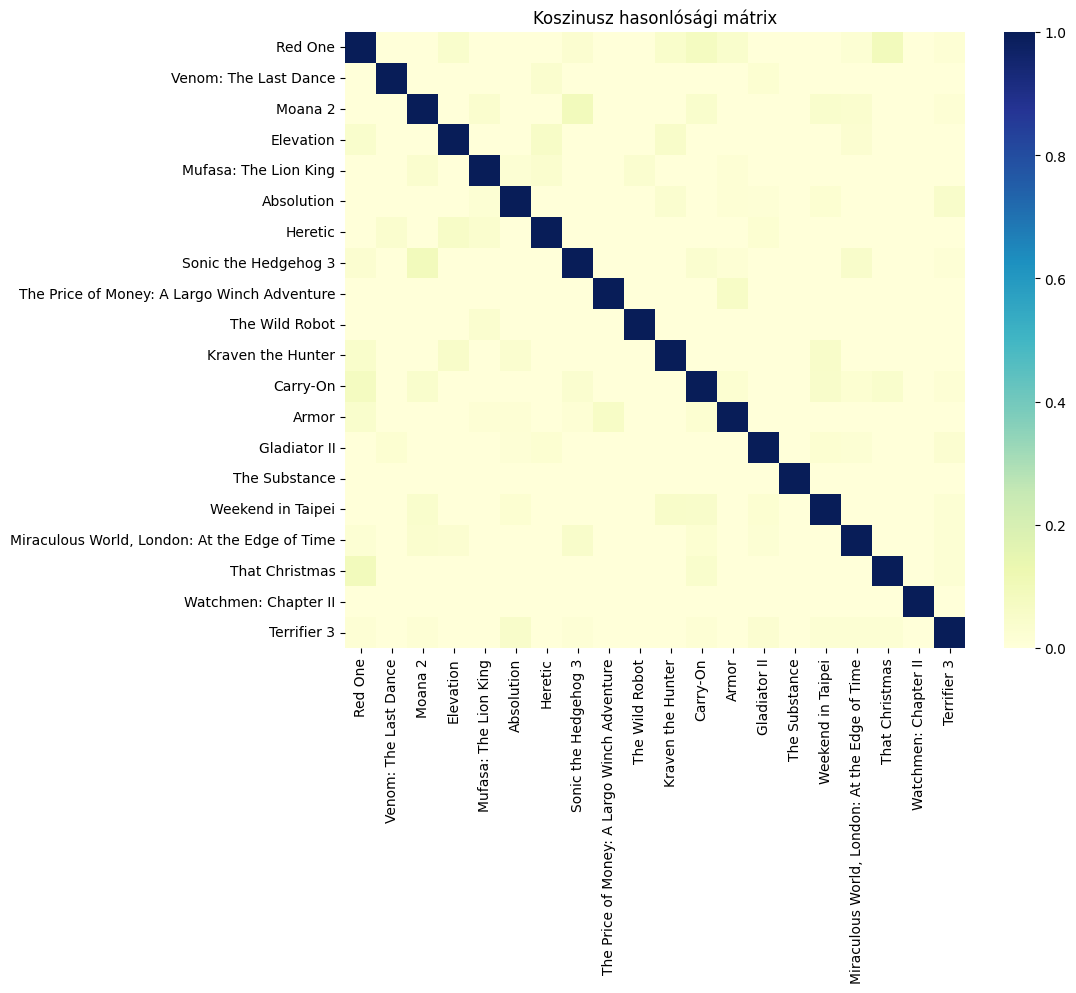

In [37]:
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim, xticklabels=df['title'], yticklabels=df['title'], cmap="YlGnBu")
plt.title("Koszinusz hasonlósági mátrix")
plt.show()

## Filmek UMAP vetítése (TF-IDF mátrix alapján)

In [38]:
pip install umap-learn matplotlib plotly

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


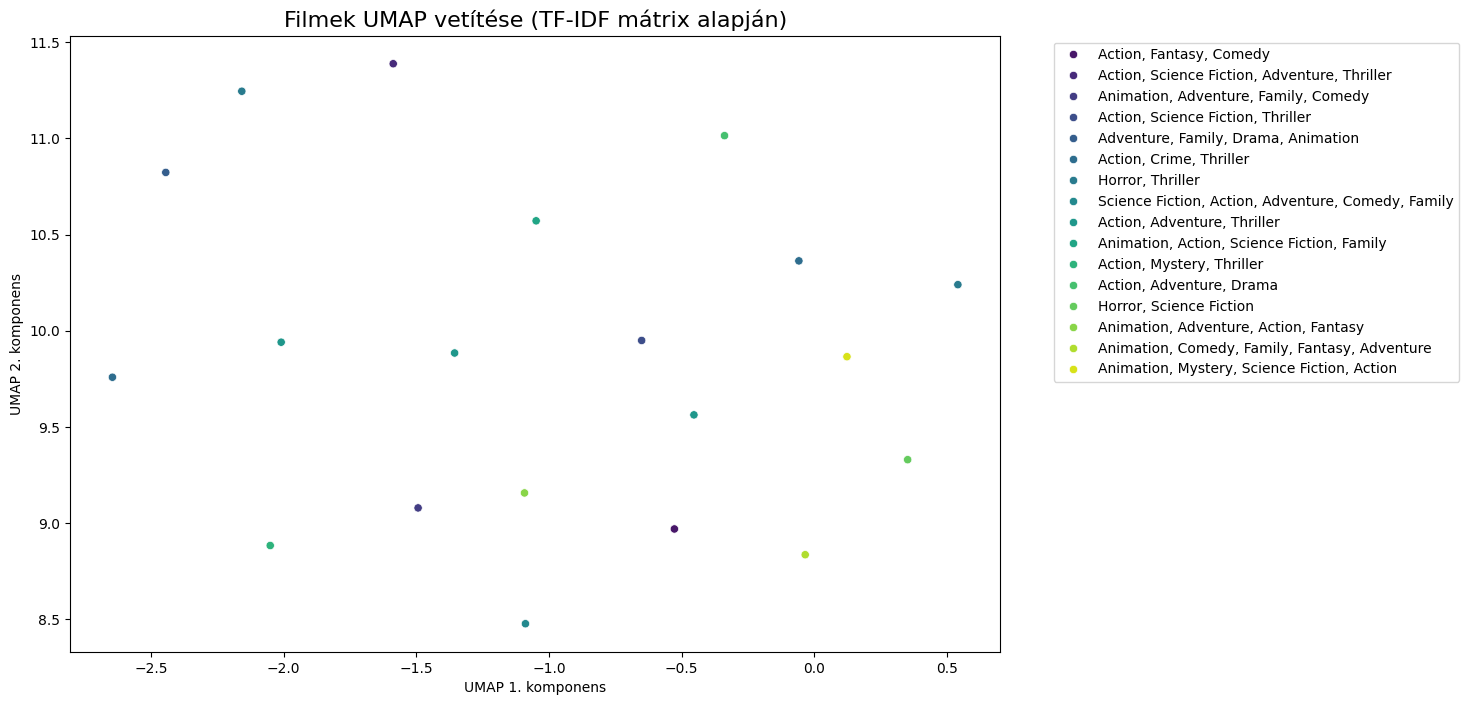

In [39]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# UMAP model létrehozása és dimenziócsökkentés 2D-re
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embedding = umap_model.fit_transform(tfidf_matrix.toarray())

# 2D scatter plot a filmekhez
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=umap_embedding[:, 0],
    y=umap_embedding[:, 1],
    hue=df['genres'],
    palette="viridis",
    legend='full'
)
plt.title("Filmek UMAP vetítése (TF-IDF mátrix alapján)", fontsize=16)
plt.xlabel("UMAP 1. komponens")
plt.ylabel("UMAP 2. komponens")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()